In [1]:
import glob
import numpy as np
import pandas as pd
import plotly
import matplotlib.pyplot as plt
from scipy import signal
import scipy
from scipy.ndimage import gaussian_filter1d
import matplotlib.lines as mlines


# Loading the data

In [2]:
#Sea-level curves
geo_wave_100=np.arange(-3*np.pi, -1*np.pi, (((3*np.pi)-(1*np.pi))/1e2))
rounding=2

A25m=25/2 #This means amplitude is -12.5 and +12.5
A50m=50/2 #This means amplitude is -25 and +25
A100m=100/2#This means amplitude is -50 and +50
f_0_1Ma=-10e6/.1e6 #20 full cycles, each of 0.5 Ma I made negative so that SL is low and delta progrades easily
f_0_5Ma=-10e6/.5e6 #20 full cycles, each of 0.5 Ma I made negative so that SL is low and delta progrades easily
f_5Ma=-10e6/5e6 

#path='/live/share/Badlands_simulations'
# Loading the files with the metrics e.g. flexure, accumulation
Delta_SL0_Te50=pd.read_csv ('extracted_results/Synthetic/Delta_SL0_Te50.csv',sep=',', header=0)
Delta_SL_f5Myr_A25m_Te50=pd.read_csv('extracted_results/Synthetic/Delta_SL_f5Myr_A25m_Te50.csv', sep=',',header=0)
Delta_SL_f500Kyr_A25m_Te50=pd.read_csv ('extracted_results/Synthetic/Delta_SL_f500Kyr_A25m_Te50.csv',sep=',', header=0)

#Loading the sea level curves
Delta_SL_f5Myr_A25m=pd.read_csv('../../2_model_running/data/f5Myr_A25m.csv', sep=' ',header=None)
Delta_SL_f500Kyr_A25m=pd.read_csv('../../2_model_running/data/f500Kyr_A25m.csv', sep=' ',header=None)


sims=[Delta_SL0_Te50,Delta_SL_f5Myr_A25m_Te50, Delta_SL_f500Kyr_A25m_Te50]


In [3]:
#Spectral analysis
nperseg=99
nperseg=99
#Power spectra - Sea level
freqA25mf0_1Ma_1e2, psdA25mf0_1Ma_1e2=signal.welch(np.round(np.sin(geo_wave_100*f_0_1Ma),rounding)*A50m, nperseg = nperseg)
freqA25mf0_5Ma_1e2, psdA25mf0_5Ma_1e2=signal.welch(np.round(np.sin(geo_wave_100*f_0_5Ma),rounding)*A50m, nperseg = nperseg)
freqA25mf5Ma_1e2, psdA25mf5Ma_1e2=signal.welch(np.round(np.sin(geo_wave_100*f_5Ma),rounding)*A50m, nperseg = nperseg)

# Power spectra and detrending - Flexure
SW_Delta_SL_f5Myr_A25m_Te50_f_dt=signal.welch(signal.detrend(Delta_SL_f5Myr_A25m_Te50.Flexure_m[20:-1]),nperseg = nperseg)
SW_Delta_SL_f500Kyr_A25m_Te50_f_dt=signal.welch(signal.detrend(Delta_SL_f500Kyr_A25m_Te50.Flexure_m[20:-1]),nperseg = nperseg)

# Power spectra and detrending - River mouth distance
SW_Delta_SL_f5Myr_A25m_Te50_drm_dt=signal.welch(signal.detrend(Delta_SL_f5Myr_A25m_Te50.River_mouth_Lengh_m[20:-1]),nperseg = nperseg)
SW_Delta_SL_f500Kyr_A25m_Te50_drm_dt=signal.welch(signal.detrend(Delta_SL_f500Kyr_A25m_Te50.River_mouth_Lengh_m[20:-1]),nperseg = nperseg)

# Power spectra and detrending - Accumulation
SW_Delta_SL_f5Myr_A25m_Te50_acc_dt=signal.welch(signal.detrend(Delta_SL_f5Myr_A25m_Te50.Accumulation_m[20:-1]),nperseg = nperseg)
SW_Delta_SL_f500Kyr_A25m_Te50_acc_dt=signal.welch(signal.detrend(Delta_SL_f500Kyr_A25m_Te50.Accumulation_m[20:-1]),nperseg = nperseg)


In [4]:
#normalization function
def normalized(x, xmin, xmax):
    try:
        normalized = (x- xmin)/(xmax - xmin)
    except ZeroDivisionError:
        percentage = float('inf')
    return normalized

In [15]:
#Finding the global min and max

min_flex=np.zeros(len(sims))
max_flex=np.zeros(len(sims))
min_dist=np.zeros(len(sims))
max_dist=np.zeros(len(sims))

sigma=[6,4,1]
for i in np.arange(0,len(sims), 1):
    min_flex[i]=min(gaussian_filter1d(sims[i].Flexure_m,sigma[i]))
    max_flex[i]=max(gaussian_filter1d(sims[i].Flexure_m,sigma[i]))
    min_dist[i]=min(gaussian_filter1d(sims[i].X[1:-1],sigma[i]))
    max_dist[i]=max(gaussian_filter1d(sims[i].X[1:-1],sigma[i]))
    

#calculating the maximum rate of flexure
max_rate_flex= np.zeros(len(sims))
#mm/yr
for i in np.arange(0,len(sims), 1):
    max_rate_flex[i]=abs(np.round((min_flex[i]*1e3)/(12*1e6),3))
    
max_rate_flex

array([0.103, 0.075, 0.074])

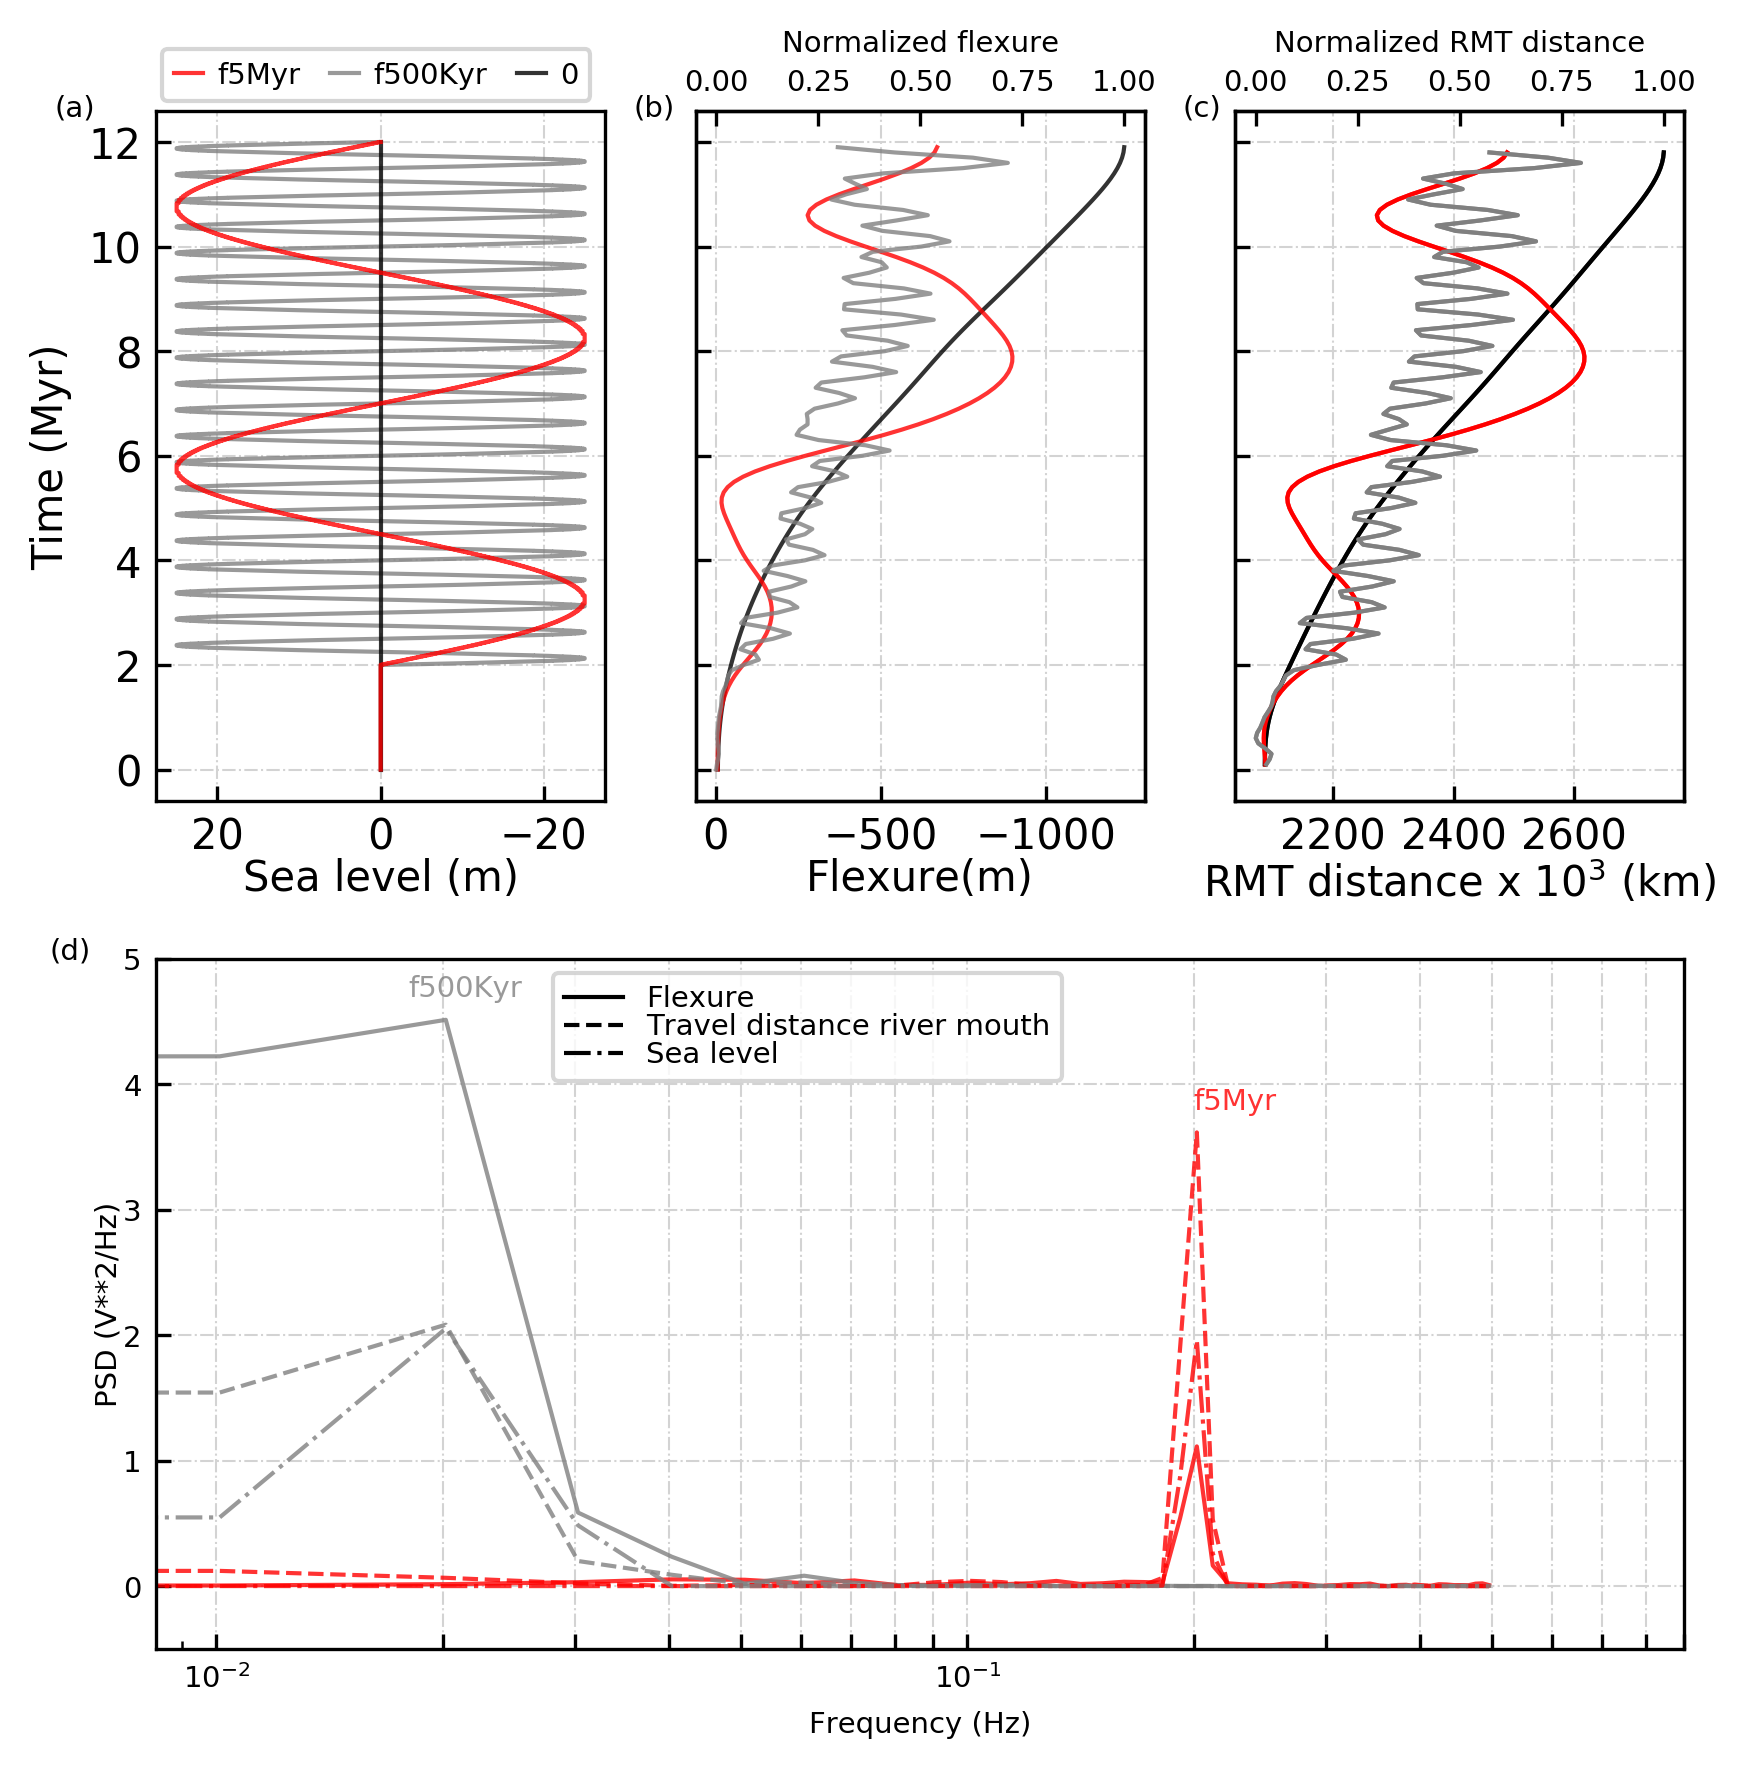

In [6]:
#Flexure&normalize flexure, power spectra at the bottom

nrows=2; ncols=3

fig,axes = plt.subplots(nrows=nrows,ncols=ncols, figsize = (15/2.54, 15/2.54), dpi=300, sharey=True)
colors=['black',  'red','grey']
plt.rc("font", size=7); plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42
abc=['(a)', '(b)', '(c)']
xabc=[40,250,1.95e3]
alpha=0.8
sigma=[6,4,1]

nfile=len(Delta_SL0_Te50.X)
ts=np.arange(0,nfile,1)
realtime=(ts*10e6)/100

SLf=1e-4
Ff=1e-6
DRMf=1e-12

###########
#First row#
###########
#Sea level
axes.flatten()[0].plot(Delta_SL_f5Myr_A25m[1],Delta_SL_f5Myr_A25m[0]/1e6, color=colors[1], linewidth=1, alpha=alpha, label='f5Myr', zorder=3) 
axes.flatten()[0].plot(Delta_SL_f500Kyr_A25m[1],Delta_SL_f500Kyr_A25m[0]/1e6, color=colors[2], linewidth=1, alpha=alpha, label='f500Kyr') 
axes.flatten()[0].plot([0, 0],[0, 12], color=colors[0], linewidth=1, alpha=alpha, label='0')

for i in np.arange(0,len(sims), 1):
    axes.flatten()[1].plot(gaussian_filter1d(sims[i].Flexure_m,sigma[i]), realtime/1e6,
                        color=colors[i], linewidth=1, alpha=alpha) 
    axes.flatten()[i].text(xabc[i], 12.5, str(abc[i]))


ax1t = axes.flatten()[1].twiny() 
for i in np.arange(0,len(sims), 1):
    ax1t.plot(normalized(gaussian_filter1d(sims[i].Flexure_m,sigma[i])
                        , min(min_flex)
                        , max(max_flex)), realtime/1e6,
            color=colors[i], linewidth=1, alpha=0, ) 

for i in np.arange(0,len(sims), 1):
    axes.flatten()[2].plot(gaussian_filter1d(sims[i].X[1:-1]/1e3,sigma[i]), realtime[1:-1]/1e6,
                        color=colors[i], linewidth=1, alpha=alpha) 

ax2t = axes.flatten()[2].twiny() 
for i in np.arange(0,len(sims), 1):
    ax2t.plot(normalized(gaussian_filter1d(sims[i].X[1:-1],sigma[i])
                        , min(min_dist)
                        , max(max_dist)), realtime[1:-1]/1e6,
            color=colors[i], linewidth=1, alpha=1 ) 
# Top Legend 
axes.flatten()[0].legend(bbox_to_anchor=[1,1.11], ncol=3,
                         labelspacing=0.1, columnspacing=1, handlelength=1, handletextpad=0.5)
axes.flatten()[0].set_ylabel('Time (Myr)')

###############
#Power spectra#
###############
axb=plt.subplot2grid((nrows,ncols),(nrows-1,0), colspan=3)
#Flexure
axb.semilogx(SW_Delta_SL_f500Kyr_A25m_Te50_f_dt[0], SW_Delta_SL_f500Kyr_A25m_Te50_f_dt[1]*Ff, c='red', linewidth=1, alpha=alpha, label='f5Myr flexure')
axb.semilogx(SW_Delta_SL_f5Myr_A25m_Te50_f_dt[0], SW_Delta_SL_f5Myr_A25m_Te50_f_dt[1]*Ff, c='grey', linewidth=1, alpha=alpha, label='f500Kyr flexure')
#Distance to river mouth
axb.semilogx(SW_Delta_SL_f500Kyr_A25m_Te50_drm_dt[0], SW_Delta_SL_f500Kyr_A25m_Te50_drm_dt[1]*DRMf,'--', linewidth=1, alpha=alpha,c='red', label='f5Myr river mouth')
axb.semilogx(SW_Delta_SL_f5Myr_A25m_Te50_drm_dt[0], SW_Delta_SL_f5Myr_A25m_Te50_drm_dt[1]*DRMf, '--', linewidth=1, alpha=alpha, c='grey', label='f500Kyr river mouth')
#Sea level
axb.semilogx(freqA25mf0_5Ma_1e2, psdA25mf0_5Ma_1e2*SLf,'-.', label='f5Myr Sea Level', c='red', linewidth=1, alpha=alpha)
axb.semilogx(freqA25mf5Ma_1e2, psdA25mf5Ma_1e2*SLf, '-.', label='f500Kyr Sea Level', c='grey', linewidth=1, alpha=alpha)
axb.text(0.018,4.7, 'f500Kyr', color='grey',  alpha=alpha)
axb.text(0.2,3.8, 'f5Myr', color='red' , alpha=alpha)
axb.set_xlabel('Frequency (Hz)')
axb.set_ylabel('PSD (V**2/Hz)',labelpad=0.10)
axb.set_ylim([-0.5, 5])

############
##Formating#
############
axb.text(6e-3,5, s='(d)')
axb.set_xticks(np.append(np.arange(1e-2, 1e-1, 1e-2), np.arange(1e-1, 1e-0, 1e-1)))
axb.tick_params(direction= 'in', which='both')
axb.grid(color='lightgrey', linestyle='-.', linewidth=0.5)


# Bottom Legend 
sea_level = mlines.Line2D([], [], color='k', linestyle='-.', linewidth=1, label='Sea level')
flexure= mlines.Line2D([], [], color='k',linewidth=1, label='Flexure')
distance= mlines.Line2D([], [], color='k',linestyle='--', linewidth=1,label='Travel distance river mouth')
axb.legend(bbox_to_anchor=[0.25,1],handles=[flexure, distance,sea_level],  labelspacing=0.001)


ax1t.tick_params(direction= 'in', which='both')
ax2t.tick_params(direction= 'in', which='both')
ax2t.tick_params([])

ax1t.set_xlabel('Normalized flexure') 
ax2t.set_xlabel('Normalized RMT distance') 


xlabels= ['Sea level (m)', 'Flexure(m)', 'RMT distance x $10^3$ (km)', '', 'Flexural departure (m)', 'RMT distance departure (km)']
for i in np.arange(0, ncols*nrows,1):
    axes.flatten()[i].tick_params(direction= 'in', which='both')
    axes.flatten()[i].grid(color='lightgrey', linestyle='-.', linewidth=0.5)
    if i<=1:
        axes.flatten()[i].invert_xaxis()

    if i<=5:
        axes.flatten()[i].set_xlabel(str(xlabels[i]), labelpad=0.01)
    
fig.tight_layout()

# fig.savefig('./images/Fig6_NormalizedFlexure&Power_spectra_synthetic_simulations.jpg')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: RuntimeWarning:

divide by zero encountered in true_divide



Text(0.5, 0, 'Rates (mm/yr)')

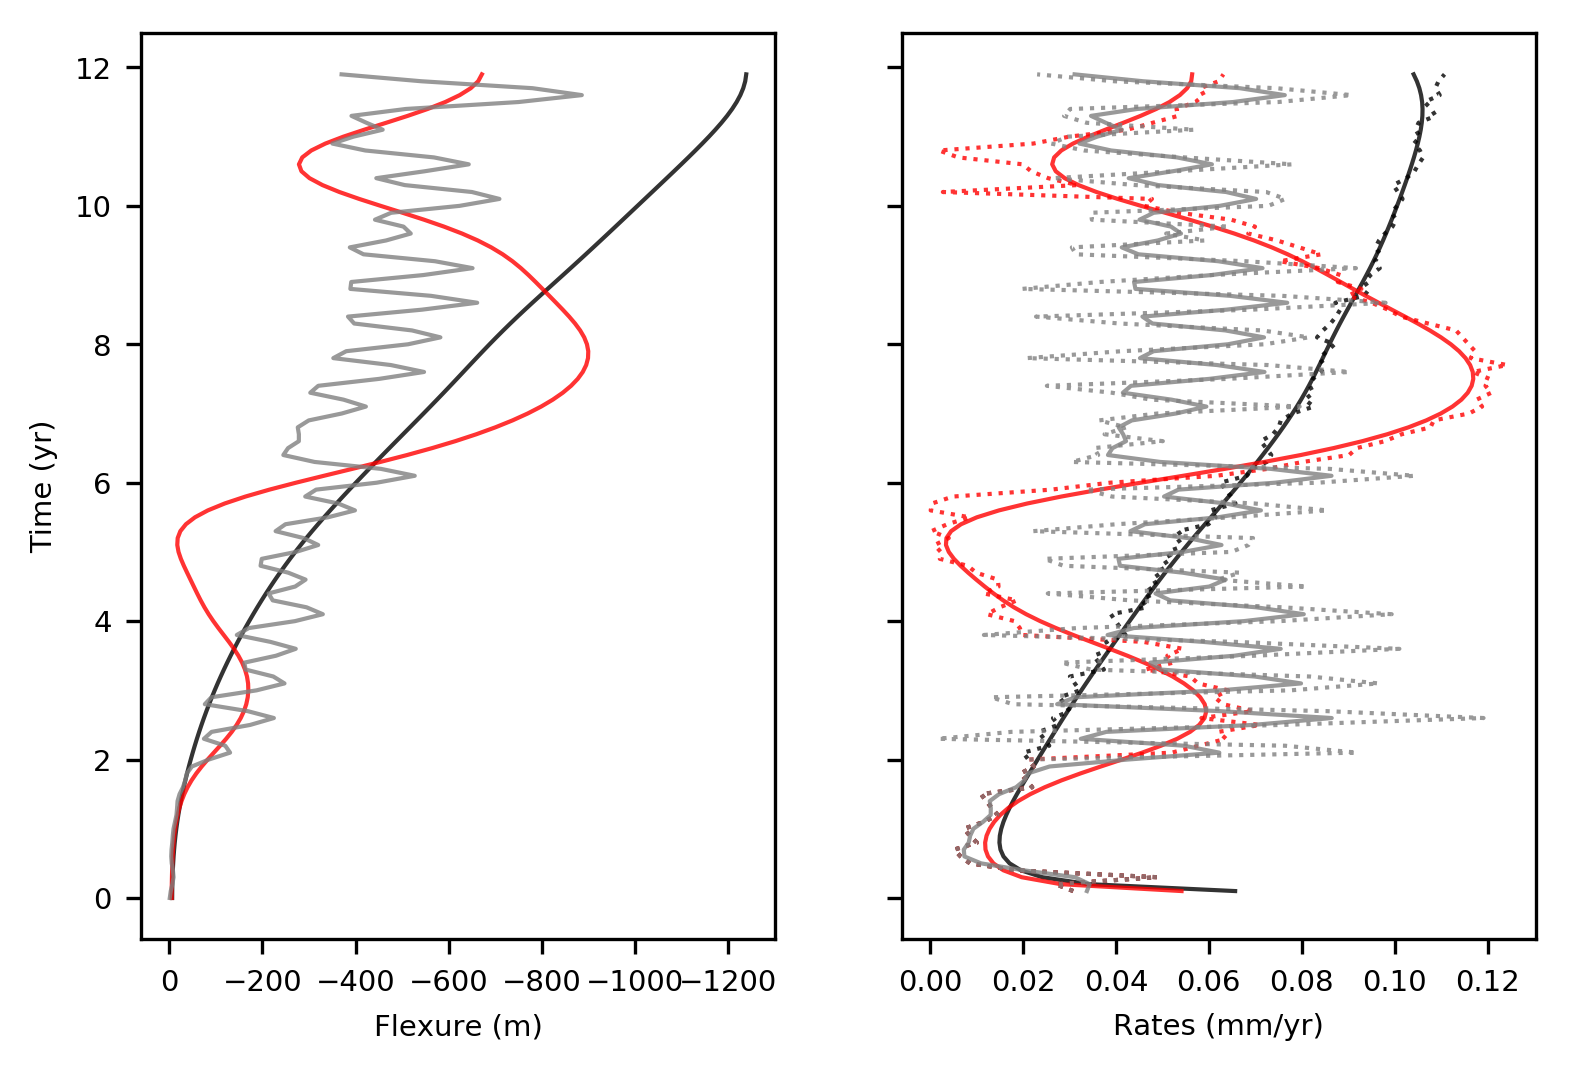

In [46]:
#Rates of flexure 
fig,axes = plt.subplots(nrows=1,ncols=2,dpi=300, sharey=True)

for i in np.arange(0,len(sims), 1):
    
    axes.flatten()[0].plot(gaussian_filter1d(sims[i].Flexure_m,sigma[i]), realtime/1e6,
                        color=colors[i], linewidth=1, alpha=alpha) 
#     axes.flatten()[0].plot(np.gradient(gaussian_filter1d(sims[i].Flexure_m,sigma[i]))/1e5, realtime/1e6,
#                         color=colors[i], linewidth=1, alpha=alpha) 
#     axes.flatten()[0].plot(np.gradient(sims[i].Flexure_m)/1e5, realtime/1e6,
#                         color=colors[i], linewidth=1, alpha=alpha, linestyle=':') 
#     axes.flatten()[1].plot(abs(np.gradient(gaussian_filter1d(sims[i].Flexure_m,sigma[i]))/1e5), realtime/1e6,
#                         color=colors[i], linewidth=1, alpha=alpha) 
    axes.flatten()[1].plot(abs(gaussian_filter1d(sims[i].Flexure_m*1e3,sigma[i]))/realtime, realtime/1e6,
                        color=colors[i], linewidth=1, alpha=alpha)
    axes.flatten()[1].plot(abs(sims[i].Flexure_m*1e3)/realtime, realtime/1e6,
                        color=colors[i], linewidth=1, alpha=alpha, linestyle=':')
axes.flatten()[0].invert_xaxis()
axes.flatten()[0].set_ylabel('Time (yr)')
axes.flatten()[0].set_xlabel('Flexure (m)')
axes.flatten()[1].set_xlabel('Rates (mm/yr)')


#     max_rate_flex[i]=abs(np.round((min_flex[i]*1e3)/(12*1e6),3))


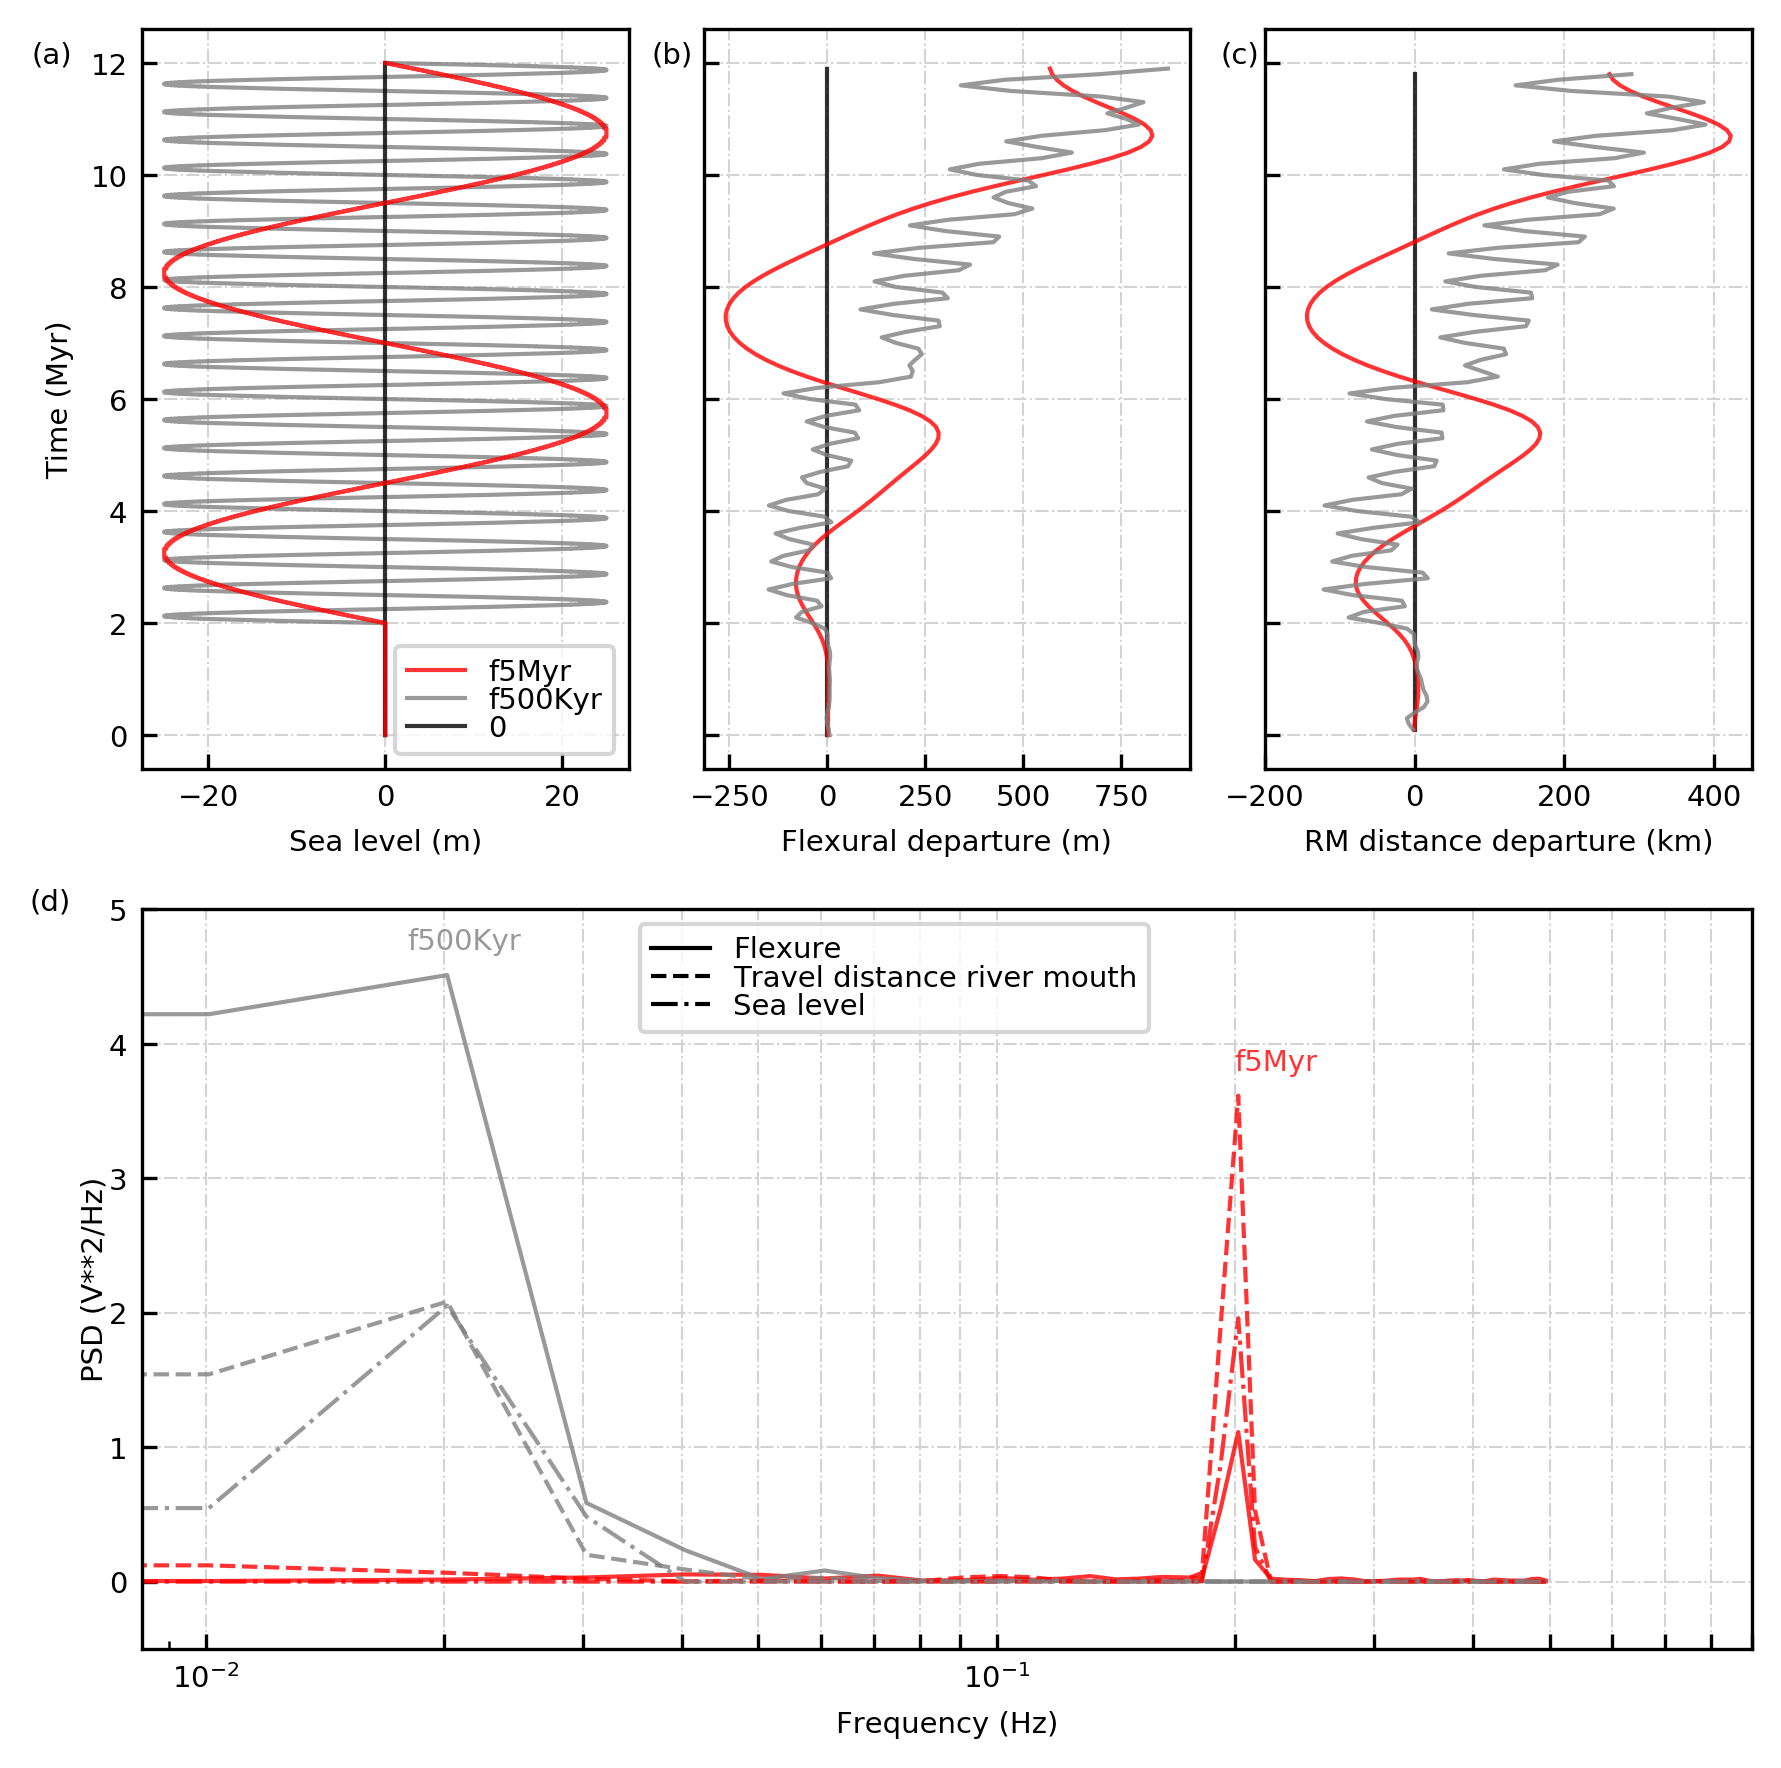

In [9]:
# Flexural Departures and power spectra 
nrows=2
ncols=3

fig,axes = plt.subplots(nrows=nrows,ncols=ncols, figsize = (15/2.54, 15/2.54), dpi=300, sharey=True)
colors=['black',  'red','grey']
plt.rc("font", size=7); plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42
abc=['(a)', '(b)', '(c)']
xabc=[-40, -450, -260]
alpha=0.8
sigma=[6,4,1]

nfile=len(Delta_SL0_Te50.X)
ts=np.arange(0,nfile,1)
realtime=(ts*10e6)/100

SLf=1e-4
Ff=1e-6
DRMf=1e-12

#########
#Top row#
#########
#Sea level
axes.flatten()[0].plot(Delta_SL_f5Myr_A25m[1],Delta_SL_f5Myr_A25m[0]/1e6, color=colors[1], linewidth=1, alpha=alpha, label='f5Myr', zorder=3) 
axes.flatten()[0].plot(Delta_SL_f500Kyr_A25m[1],Delta_SL_f500Kyr_A25m[0]/1e6, color=colors[2], linewidth=1, alpha=alpha, label='f500Kyr') 
axes.flatten()[0].plot([0, 0],[0, 12], color=colors[0], linewidth=1, alpha=alpha, label='0')
for i in np.arange(0,len(sims), 1):
    #departures flexure
    axes.flatten()[1].plot(gaussian_filter1d(sims[i].Flexure_m,sigma[i])-
         gaussian_filter1d(sims[0].Flexure_m, 6),realtime/1e6, color=colors[i], linewidth=1, alpha=alpha) 
    #departures distance
    axes.flatten()[2].plot(gaussian_filter1d(sims[0].X[1:-1]/1e3, 6)- gaussian_filter1d(sims[i].X[1:-1]/1e3,sigma[i]),
                           realtime[1:-1]/1e6, color=colors[i], linewidth=1, alpha=alpha)
    axes.flatten()[i].text(xabc[i], 12, str(abc[i]))

###############
#Power spectra#
###############
axb=plt.subplot2grid((nrows,ncols),(nrows-1,0), colspan=3)
#Flexure
axb.semilogx(SW_Delta_SL_f500Kyr_A25m_Te50_f_dt[0], SW_Delta_SL_f500Kyr_A25m_Te50_f_dt[1]*Ff, c='red', linewidth=1, alpha=alpha, label='f5Myr flexure')
axb.semilogx(SW_Delta_SL_f5Myr_A25m_Te50_f_dt[0], SW_Delta_SL_f5Myr_A25m_Te50_f_dt[1]*Ff, c='grey', linewidth=1, alpha=alpha, label='f500Kyr flexure')
#Distance to river mouth
axb.semilogx(SW_Delta_SL_f500Kyr_A25m_Te50_drm_dt[0], SW_Delta_SL_f500Kyr_A25m_Te50_drm_dt[1]*DRMf,'--', linewidth=1, alpha=alpha,c='red', label='f5Myr river mouth')
axb.semilogx(SW_Delta_SL_f5Myr_A25m_Te50_drm_dt[0], SW_Delta_SL_f5Myr_A25m_Te50_drm_dt[1]*DRMf, '--', linewidth=1, alpha=alpha, c='grey', label='f500Kyr river mouth')
#Sea level
axb.semilogx(freqA25mf0_5Ma_1e2, psdA25mf0_5Ma_1e2*SLf,'-.', label='f5Myr Sea Level', c='red', linewidth=1, alpha=alpha)
axb.semilogx(freqA25mf5Ma_1e2, psdA25mf5Ma_1e2*SLf, '-.', label='f500Kyr Sea Level', c='grey', linewidth=1, alpha=alpha)
axb.text(0.018,4.7, 'f500Kyr', color='grey',  alpha=alpha)
axb.text(0.2,3.8, 'f5Myr', color='red' , alpha=alpha)
axb.set_xlabel('Frequency (Hz)')
axb.set_ylabel('PSD (V**2/Hz)',labelpad=0.10)
axb.set_ylim([-0.5, 5])

###########
#Formating#
###########
axb.text(6e-3,5, s='(d)')
axb.set_xticks(np.append(np.arange(1e-2, 1e-1, 1e-2), np.arange(1e-1, 1e-0, 1e-1)))
axb.tick_params(direction= 'in', which='both')
axb.grid(color='lightgrey', linestyle='-.', linewidth=0.5)
# Top Legend 
axes.flatten()[0].legend( ncol=1,labelspacing=0.01, loc='lower right')


# Bottom Legend 
sea_level = mlines.Line2D([], [], color='k', linestyle='-.', linewidth=1, label='Sea level')
flexure= mlines.Line2D([], [], color='k',linewidth=1, label='Flexure')
distance= mlines.Line2D([], [], color='k',linestyle='--', linewidth=1,label='Travel distance river mouth')
axb.legend(bbox_to_anchor=[0.3,1],handles=[flexure, distance,sea_level],  labelspacing=0.01)

axes.flatten()[0].set_xlabel('Sea level (m)')
axes.flatten()[0].set_ylabel('Time (Myr)')
axes.flatten()[0].grid(color='lightgrey', linestyle='-.', linewidth=0.5)
axes.flatten()[0].tick_params(direction= 'in')
axes.flatten()[1].set_xlabel('Flexural departure (m)')
axes.flatten()[2].set_xlabel('RM distance departure (km)')
axes.flatten()[2].set_xlim([-200, 450])
axes.flatten()[1].grid(color='lightgrey', linestyle='-.', linewidth=0.5)
axes.flatten()[2].grid(color='lightgrey', linestyle='-.', linewidth=0.5)

for i in np.arange(0, ncols,1):
    axes.flatten()[i].tick_params(direction= 'in', which='both')
    
    
fig.tight_layout()

# fig.savefig('./images/Fig6_Departures&Power_spectra_synthetic_simulations.jpg')

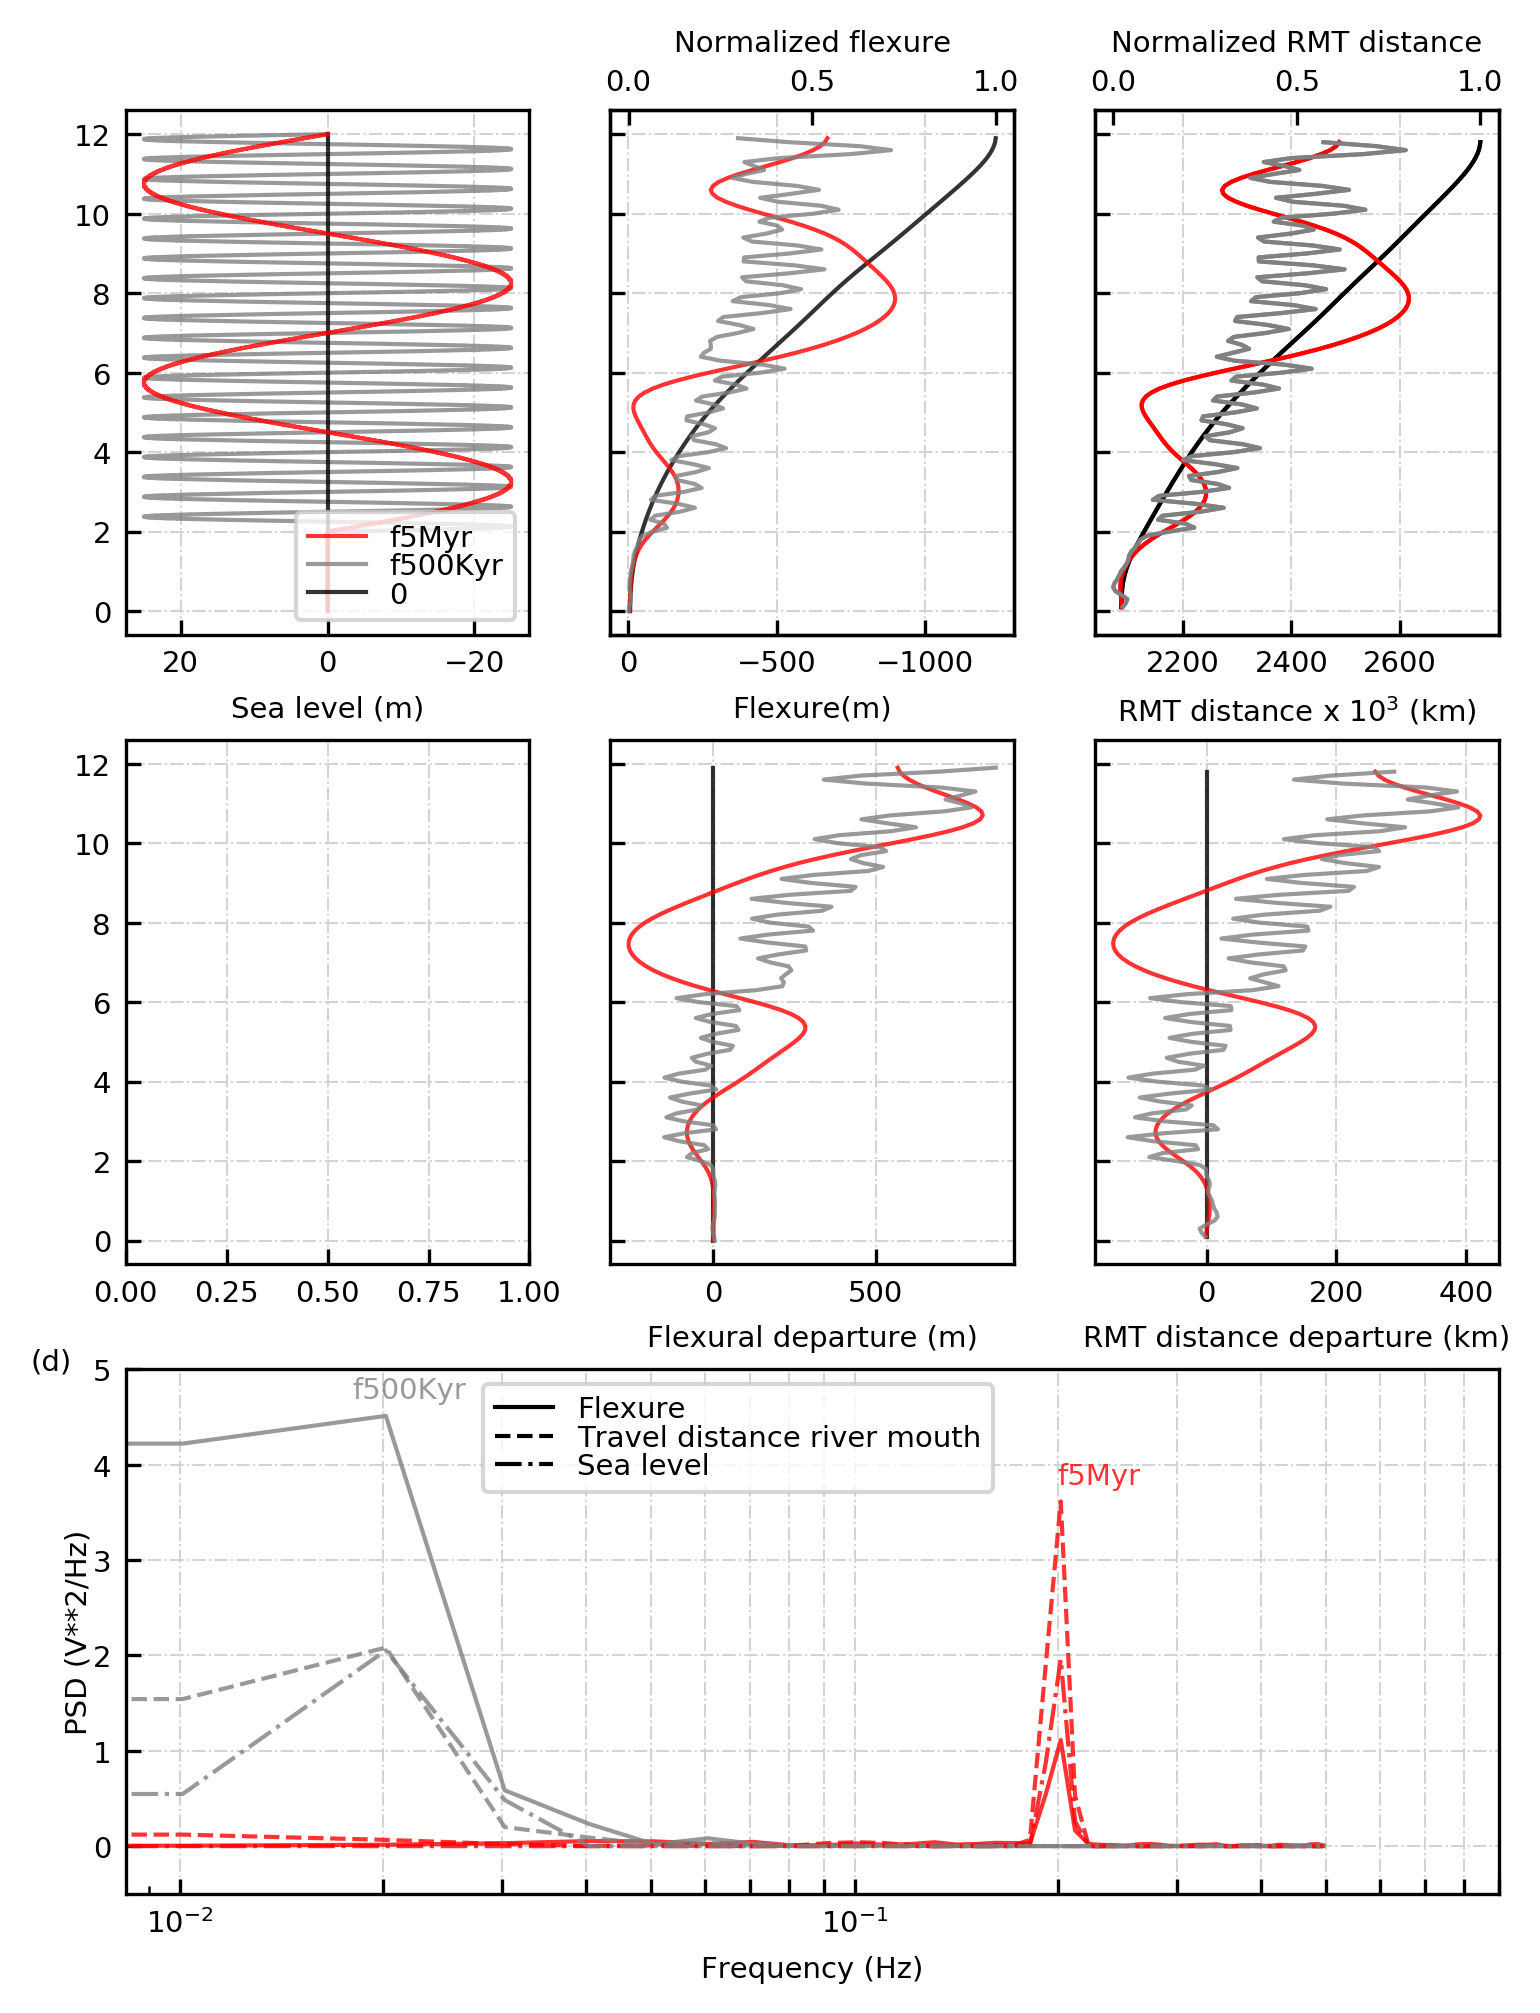

In [10]:
#Flexure, flexural departures and power spectra at the bottom
nrows=3
ncols=3

fig,axes = plt.subplots(nrows=nrows,ncols=ncols, figsize = (15/2.54, 20/2.54), dpi=300, sharey=True)
colors=['black',  'red','grey']
plt.rc("font", size=7); plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42
abc=['(a)', '(b)', '(c)']
xabc=[-40, -450, -260]
alpha=0.8
sigma=[6,4,1]

nfile=len(Delta_SL0_Te50.X)
ts=np.arange(0,nfile,1)
realtime=(ts*10e6)/100

SLf=1e-4
Ff=1e-6
DRMf=1e-12

#########
#Top row#
#########
#Sea level
axes.flatten()[0].plot(Delta_SL_f5Myr_A25m[1],Delta_SL_f5Myr_A25m[0]/1e6, color=colors[1], linewidth=1, alpha=alpha, label='f5Myr', zorder=3) 
axes.flatten()[0].plot(Delta_SL_f500Kyr_A25m[1],Delta_SL_f500Kyr_A25m[0]/1e6, color=colors[2], linewidth=1, alpha=alpha, label='f500Kyr') 
axes.flatten()[0].plot([0, 0],[0, 12], color=colors[0], linewidth=1, alpha=alpha, label='0')

for i in np.arange(0,len(sims), 1):
    axes.flatten()[1].plot(gaussian_filter1d(sims[i].Flexure_m,sigma[i]), realtime/1e6,
                        color=colors[i], linewidth=1, alpha=alpha) 

ax1t = axes.flatten()[1].twiny() 
for i in np.arange(0,len(sims), 1):
    ax1t.plot(normalized(gaussian_filter1d(sims[i].Flexure_m,sigma[i])
                        , min(min_flex)
                        , max(max_flex)), realtime/1e6,
            color=colors[i], linewidth=1, alpha=0, ) 

for i in np.arange(0,len(sims), 1):
    axes.flatten()[2].plot(gaussian_filter1d(sims[i].X[1:-1]/1e3,sigma[i]), realtime[1:-1]/1e6,
                        color=colors[i], linewidth=1, alpha=alpha) 

ax2t = axes.flatten()[2].twiny() 
for i in np.arange(0,len(sims), 1):
    ax2t.plot(normalized(gaussian_filter1d(sims[i].X[1:-1],sigma[i])
                        , min(min_dist)
                        , max(max_dist)), realtime[1:-1]/1e6,
            color=colors[i], linewidth=1, alpha=1 ) 

for i in np.arange(0,len(sims), 1):
    #departures flexure
    axes.flatten()[4].plot(gaussian_filter1d(sims[i].Flexure_m,sigma[i])-
         gaussian_filter1d(sims[0].Flexure_m, 6),realtime/1e6, color=colors[i], linewidth=1, alpha=alpha) 
    #departures distance
    axes.flatten()[5].plot(gaussian_filter1d(sims[0].X[1:-1]/1e3, 6)- gaussian_filter1d(sims[i].X[1:-1]/1e3,sigma[i]),
                           realtime[1:-1]/1e6, color=colors[i], linewidth=1, alpha=alpha)
#     axes.flatten()[i].text(xabc[i], 12, str(abc[i]))

###############
#Power spectra#
###############
axb=plt.subplot2grid((nrows,ncols),(nrows-1,0), colspan=3)
#Flexure
axb.semilogx(SW_Delta_SL_f500Kyr_A25m_Te50_f_dt[0], SW_Delta_SL_f500Kyr_A25m_Te50_f_dt[1]*Ff, c='red', linewidth=1, alpha=alpha, label='f5Myr flexure')
axb.semilogx(SW_Delta_SL_f5Myr_A25m_Te50_f_dt[0], SW_Delta_SL_f5Myr_A25m_Te50_f_dt[1]*Ff, c='grey', linewidth=1, alpha=alpha, label='f500Kyr flexure')
#Distance to river mouth
axb.semilogx(SW_Delta_SL_f500Kyr_A25m_Te50_drm_dt[0], SW_Delta_SL_f500Kyr_A25m_Te50_drm_dt[1]*DRMf,'--', linewidth=1, alpha=alpha,c='red', label='f5Myr river mouth')
axb.semilogx(SW_Delta_SL_f5Myr_A25m_Te50_drm_dt[0], SW_Delta_SL_f5Myr_A25m_Te50_drm_dt[1]*DRMf, '--', linewidth=1, alpha=alpha, c='grey', label='f500Kyr river mouth')
#Sea level
axb.semilogx(freqA25mf0_5Ma_1e2, psdA25mf0_5Ma_1e2*SLf,'-.', label='f5Myr Sea Level', c='red', linewidth=1, alpha=alpha)
axb.semilogx(freqA25mf5Ma_1e2, psdA25mf5Ma_1e2*SLf, '-.', label='f500Kyr Sea Level', c='grey', linewidth=1, alpha=alpha)
axb.text(0.018,4.7, 'f500Kyr', color='grey',  alpha=alpha)
axb.text(0.2,3.8, 'f5Myr', color='red' , alpha=alpha)
axb.set_xlabel('Frequency (Hz)')
axb.set_ylabel('PSD (V**2/Hz)',labelpad=0.10)
axb.set_ylim([-0.5, 5])

# ###########
# #Formating#
# ###########
axb.text(6e-3,5, s='(d)')
axb.set_xticks(np.append(np.arange(1e-2, 1e-1, 1e-2), np.arange(1e-1, 1e-0, 1e-1)))
axb.tick_params(direction= 'in', which='both')
axb.grid(color='lightgrey', linestyle='-.', linewidth=0.5)
# Top Legend 
axes.flatten()[0].legend( ncol=1,labelspacing=0.01, loc='lower right')


# Bottom Legend 
sea_level = mlines.Line2D([], [], color='k', linestyle='-.', linewidth=1, label='Sea level')
flexure= mlines.Line2D([], [], color='k',linewidth=1, label='Flexure')
distance= mlines.Line2D([], [], color='k',linestyle='--', linewidth=1,label='Travel distance river mouth')
axb.legend(bbox_to_anchor=[0.25,1],handles=[flexure, distance,sea_level],  labelspacing=0.01)


ax1t.tick_params(direction= 'in', which='both')
ax2t.tick_params(direction= 'in', which='both')
ax2t.tick_params([])

ax1t.set_xlabel('Normalized flexure') 
ax2t.set_xlabel('Normalized RMT distance') 


xlabels= ['Sea level (m)', 'Flexure(m)', 'RMT distance x $10^3$ (km)', '', 'Flexural departure (m)', 'RMT distance departure (km)']
for i in np.arange(0, ncols*nrows,1):
    axes.flatten()[i].tick_params(direction= 'in', which='both')
    axes.flatten()[i].grid(color='lightgrey', linestyle='-.', linewidth=0.5)
    if i<=1:
        axes.flatten()[i].invert_xaxis()

    if i<=5:
        axes.flatten()[i].set_xlabel(str(xlabels[i]))
    
# fig.tight_layout()

# fig.savefig('./images/Fig6_Departures&Power_spectra_synthetic_simulations.jpg')

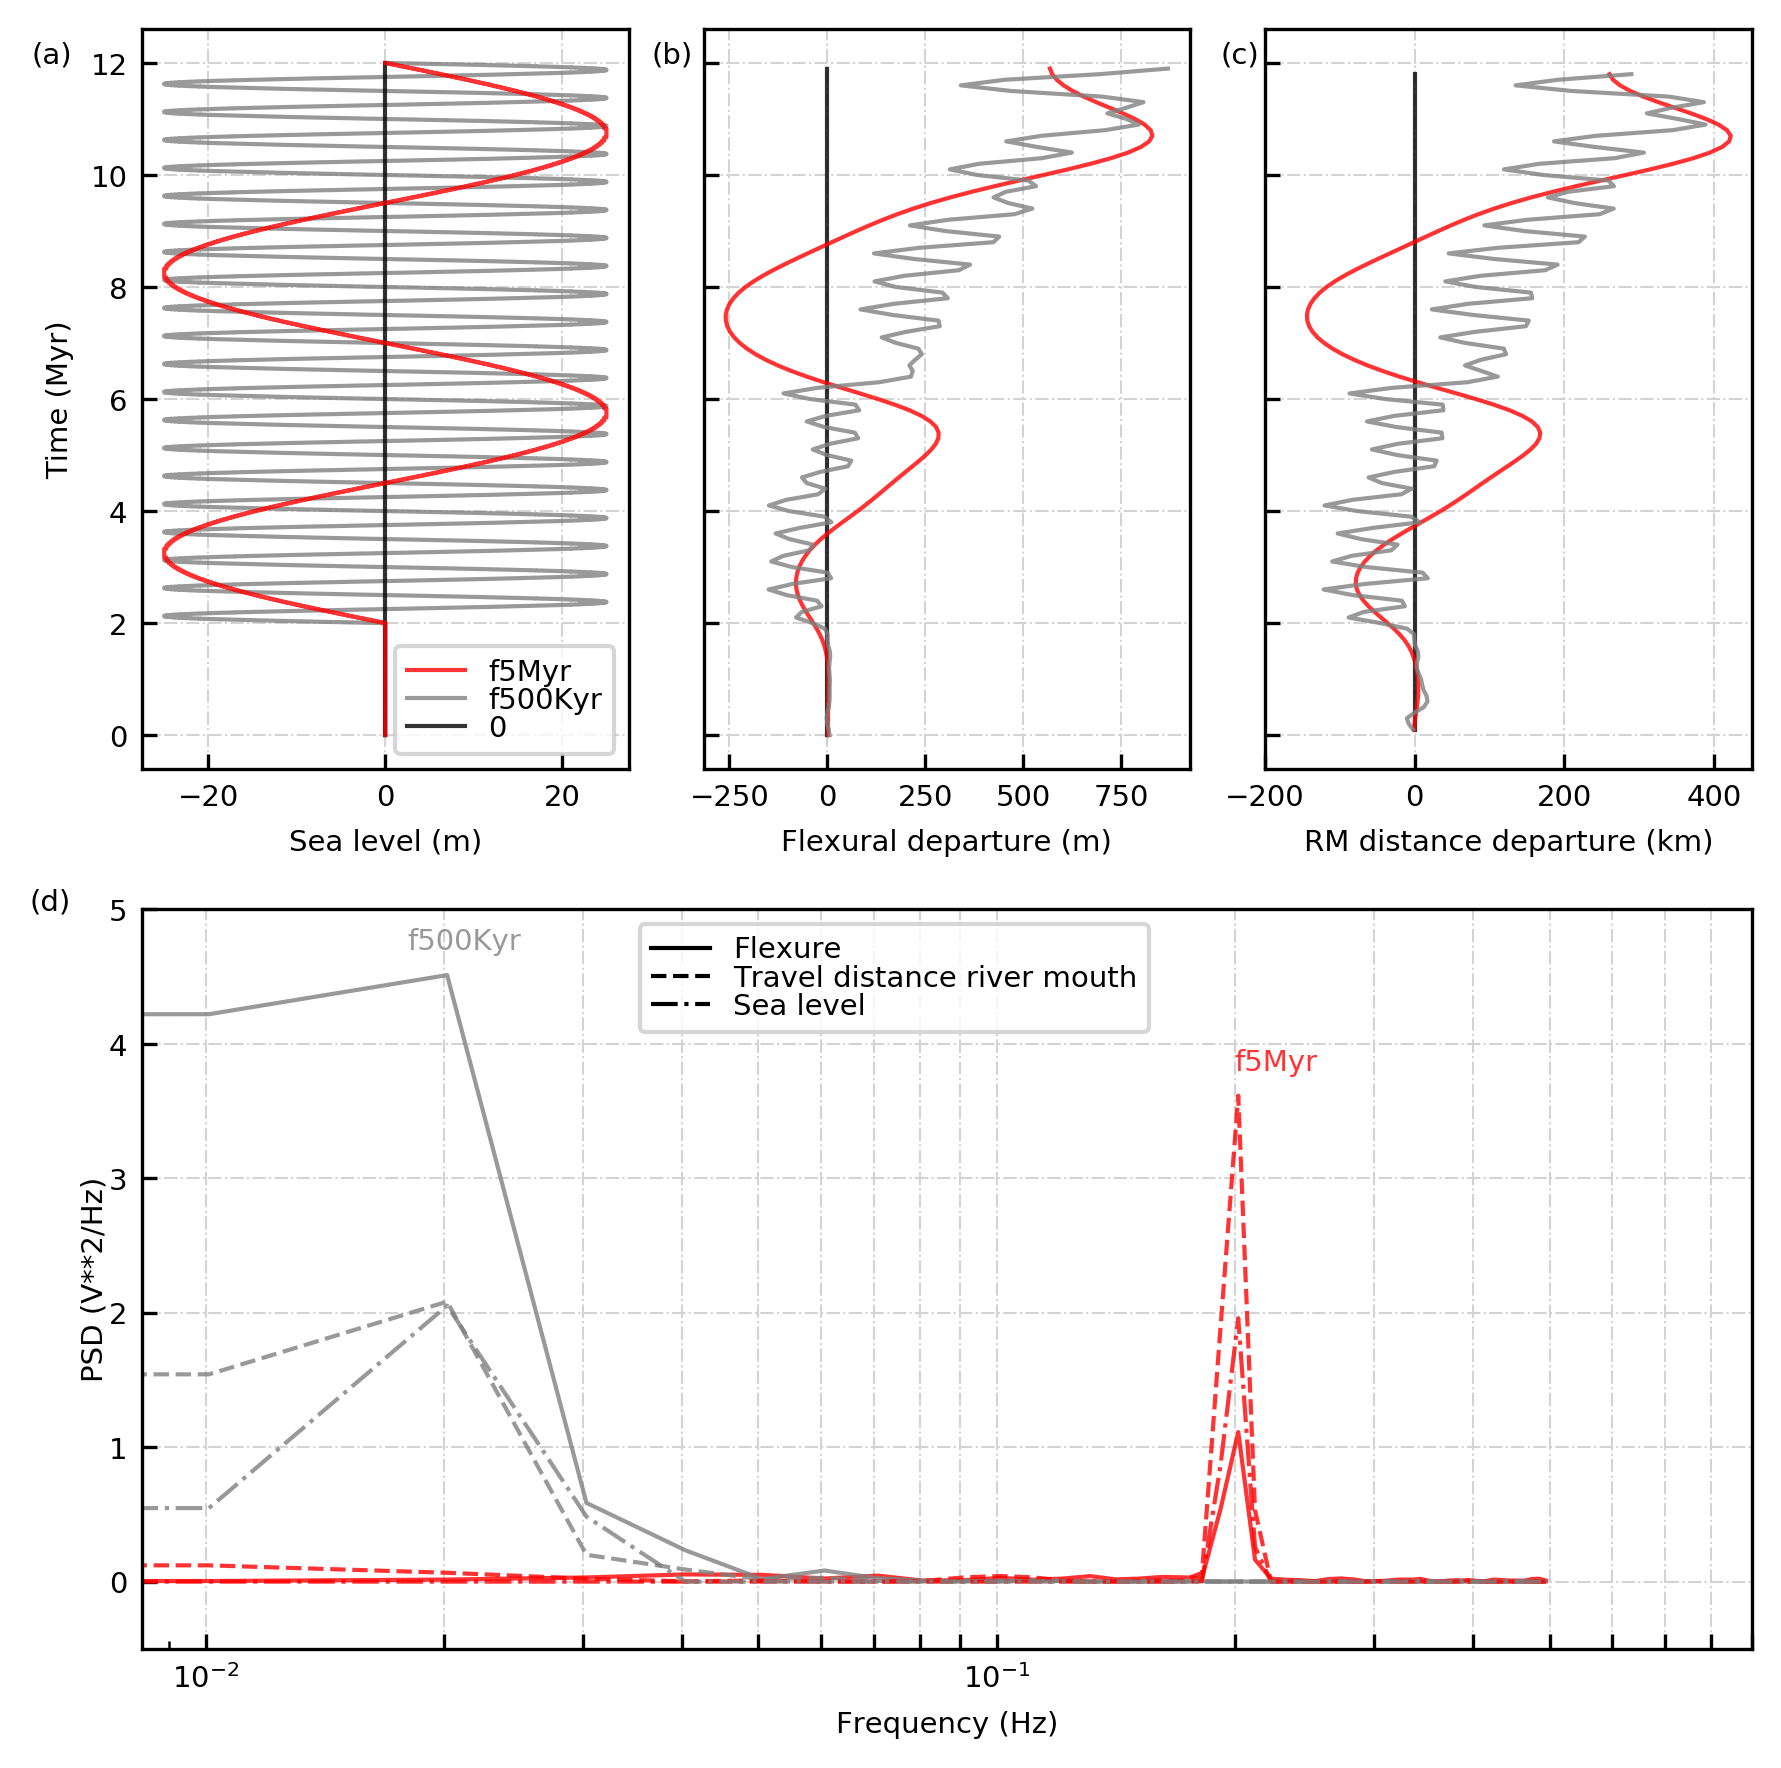

In [11]:
#Flexural departures and power spectra at the bottom
nrows=2
ncols=3

fig,axes = plt.subplots(nrows=nrows,ncols=ncols, figsize = (15/2.54, 15/2.54), dpi=300, sharey=True)
colors=['black',  'red','grey']
plt.rc("font", size=7); plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42
abc=['(a)', '(b)', '(c)']
xabc=[-40, -450, -260]
alpha=0.8
sigma=[6,4,1]

nfile=len(Delta_SL0_Te50.X)
ts=np.arange(0,nfile,1)
realtime=(ts*10e6)/100

SLf=1e-4
Ff=1e-6
DRMf=1e-12

#########
#Top row#
#########
#Sea level
axes.flatten()[0].plot(Delta_SL_f5Myr_A25m[1],Delta_SL_f5Myr_A25m[0]/1e6, color=colors[1], linewidth=1, alpha=alpha, label='f5Myr', zorder=3) 
axes.flatten()[0].plot(Delta_SL_f500Kyr_A25m[1],Delta_SL_f500Kyr_A25m[0]/1e6, color=colors[2], linewidth=1, alpha=alpha, label='f500Kyr') 
axes.flatten()[0].plot([0, 0],[0, 12], color=colors[0], linewidth=1, alpha=alpha, label='0')
for i in np.arange(0,len(sims), 1):
    #departures flexure
    axes.flatten()[1].plot(gaussian_filter1d(sims[i].Flexure_m,sigma[i])-
         gaussian_filter1d(sims[0].Flexure_m, 6),realtime/1e6, color=colors[i], linewidth=1, alpha=alpha) 
    #departures distance
    axes.flatten()[2].plot(gaussian_filter1d(sims[0].X[1:-1]/1e3, 6)- gaussian_filter1d(sims[i].X[1:-1]/1e3,sigma[i]),
                           realtime[1:-1]/1e6, color=colors[i], linewidth=1, alpha=alpha)
    axes.flatten()[i].text(xabc[i], 12, str(abc[i]))

###############
#Power spectra#
###############
axb=plt.subplot2grid((nrows,ncols),(nrows-1,0), colspan=3)
#Flexure
axb.semilogx(SW_Delta_SL_f500Kyr_A25m_Te50_f_dt[0], SW_Delta_SL_f500Kyr_A25m_Te50_f_dt[1]*Ff, c='red', linewidth=1, alpha=alpha, label='f5Myr flexure')
axb.semilogx(SW_Delta_SL_f5Myr_A25m_Te50_f_dt[0], SW_Delta_SL_f5Myr_A25m_Te50_f_dt[1]*Ff, c='grey', linewidth=1, alpha=alpha, label='f500Kyr flexure')
#Distance to river mouth
axb.semilogx(SW_Delta_SL_f500Kyr_A25m_Te50_drm_dt[0], SW_Delta_SL_f500Kyr_A25m_Te50_drm_dt[1]*DRMf,'--', linewidth=1, alpha=alpha,c='red', label='f5Myr river mouth')
axb.semilogx(SW_Delta_SL_f5Myr_A25m_Te50_drm_dt[0], SW_Delta_SL_f5Myr_A25m_Te50_drm_dt[1]*DRMf, '--', linewidth=1, alpha=alpha, c='grey', label='f500Kyr river mouth')
#Sea level
axb.semilogx(freqA25mf0_5Ma_1e2, psdA25mf0_5Ma_1e2*SLf,'-.', label='f5Myr Sea Level', c='red', linewidth=1, alpha=alpha)
axb.semilogx(freqA25mf5Ma_1e2, psdA25mf5Ma_1e2*SLf, '-.', label='f500Kyr Sea Level', c='grey', linewidth=1, alpha=alpha)
axb.text(0.018,4.7, 'f500Kyr', color='grey',  alpha=alpha)
axb.text(0.2,3.8, 'f5Myr', color='red' , alpha=alpha)
axb.set_xlabel('Frequency (Hz)')
axb.set_ylabel('PSD (V**2/Hz)',labelpad=0.10)
axb.set_ylim([-0.5, 5])

###########
#Formating#
###########
axb.text(6e-3,5, s='(d)')
axb.set_xticks(np.append(np.arange(1e-2, 1e-1, 1e-2), np.arange(1e-1, 1e-0, 1e-1)))
axb.tick_params(direction= 'in', which='both')
axb.grid(color='lightgrey', linestyle='-.', linewidth=0.5)
# Top Legend 
axes.flatten()[0].legend( ncol=1,labelspacing=0.01, loc='lower right')


# Bottom Legend 
sea_level = mlines.Line2D([], [], color='k', linestyle='-.', linewidth=1, label='Sea level')
flexure= mlines.Line2D([], [], color='k',linewidth=1, label='Flexure')
distance= mlines.Line2D([], [], color='k',linestyle='--', linewidth=1,label='Travel distance river mouth')
axb.legend(bbox_to_anchor=[0.3,1],handles=[flexure, distance,sea_level],  labelspacing=0.01)

axes.flatten()[0].set_xlabel('Sea level (m)')
axes.flatten()[0].set_ylabel('Time (Myr)')
axes.flatten()[0].grid(color='lightgrey', linestyle='-.', linewidth=0.5)
axes.flatten()[0].tick_params(direction= 'in')
axes.flatten()[1].set_xlabel('Flexural departure (m)')
axes.flatten()[2].set_xlabel('RM distance departure (km)')
axes.flatten()[2].set_xlim([-200, 450])
axes.flatten()[1].grid(color='lightgrey', linestyle='-.', linewidth=0.5)
axes.flatten()[2].grid(color='lightgrey', linestyle='-.', linewidth=0.5)

for i in np.arange(0, ncols,1):
    axes.flatten()[i].tick_params(direction= 'in', which='both')
    
    
fig.tight_layout()

# fig.savefig('./images/Fig6_Departures&Power_spectra_synthetic_simulations.jpg')

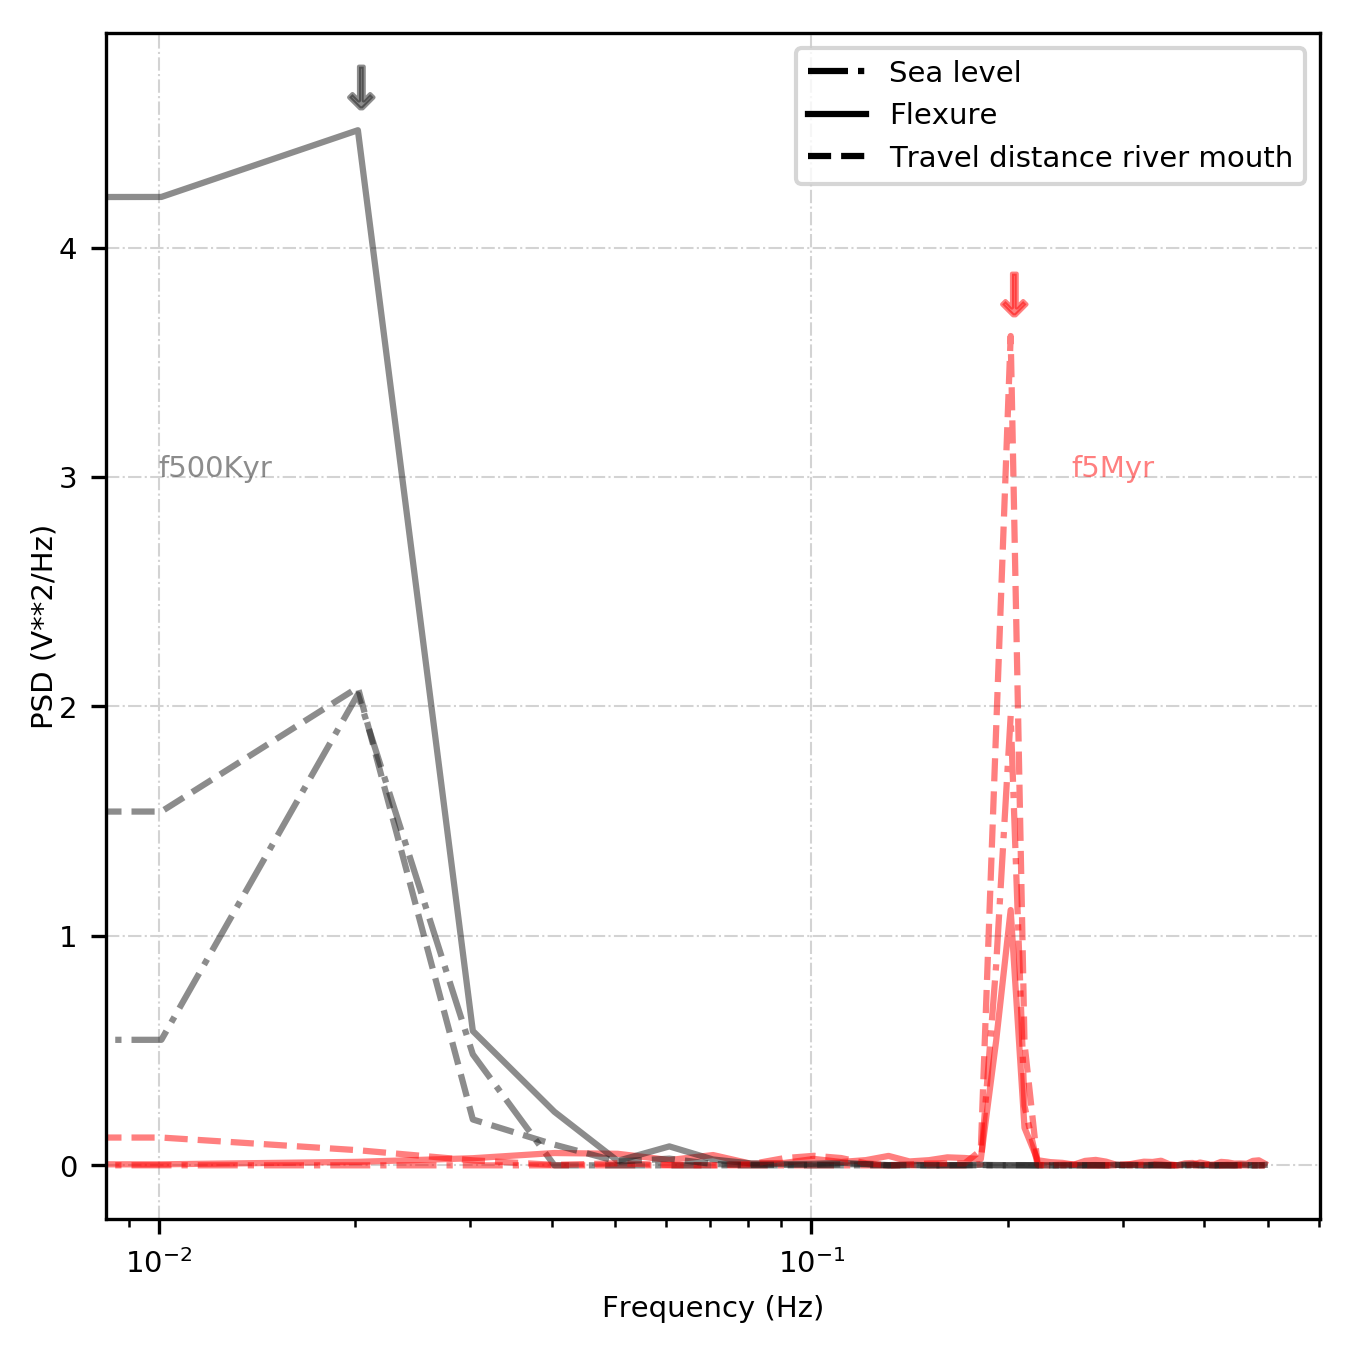

In [48]:
#only power spectra
fig,ax = plt.subplots(nrows=1,ncols=1, figsize = (11/2.54, 11/2.54), dpi=300)
plt.rc("font", size=7)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

red=(1,0,0,.5)
grey=(0.1,0.1,0.1,0.5)
# SLf=1e-1
# Ff=1e-3
# DRMf=1e-9
SLf=1e-4
Ff=1e-6
DRMf=1e-12
#Sea level
plt.semilogx(freqA25mf0_5Ma_1e2, psdA25mf0_5Ma_1e2*SLf,'-.', label='f5Myr Sea Level', c=red)
plt.semilogx(freqA25mf5Ma_1e2, psdA25mf5Ma_1e2*SLf, '-.', label='f500Kyr Sea Level', c=grey)
#Flexure
plt.semilogx(SW_Delta_SL_f500Kyr_A25m_Te50_f_dt[0], SW_Delta_SL_f500Kyr_A25m_Te50_f_dt[1]*Ff, c=red, label='f5Myr flexure')
plt.semilogx(SW_Delta_SL_f5Myr_A25m_Te50_f_dt[0], SW_Delta_SL_f5Myr_A25m_Te50_f_dt[1]*Ff, c=grey, label='f500Kyr flexure')
#Distance to river mouth
plt.semilogx(SW_Delta_SL_f500Kyr_A25m_Te50_drm_dt[0], SW_Delta_SL_f500Kyr_A25m_Te50_drm_dt[1]*DRMf,'--',c=red, label='f5Myr river mouth')
plt.semilogx(SW_Delta_SL_f5Myr_A25m_Te50_drm_dt[0], SW_Delta_SL_f5Myr_A25m_Te50_drm_dt[1]*DRMf, '--', c=grey, label='f500Kyr river mouth')
#Accumulation
# plt.semilogx(SW_Delta_SL_f5Myr_A25m_Te50_acc_dt[0], SW_Delta_SL_f5Myr_A25m_Te50_acc_dt[1]*DRMf,'-*',c=red, label='f5Myr deposition')
# plt.semilogx(SW_Delta_SL_f5Myr_A25m_Te50_acc_dt[0], SW_Delta_SL_f5Myr_A25m_Te50_acc_dt[1]*DRMf, '-*', c=grey, label='f500Kyr deposition')

# plt.axvline(0.02, color=grey, linestyle=':')
# plt.axvline(0.2, color=red, linestyle=':')

plt.plot(0.02,4.7, marker=r'$\downarrow$', color=grey, markersize=10)
plt.plot(0.2,3.8, marker=r'$\downarrow$', color=red, markersize=10)

plt.text(10**-2,3, 'f500Kyr', color=grey)
plt.text(0.25,3, 'f5Myr', color=red )


plt.tick_params(axis='both', which='major', labelsize=7)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V**2/Hz)',labelpad=0.10)
plt.legend(loc='best', borderaxespad=0.)
plt.grid(color='lightgrey', linestyle='-.', linewidth=0.5)

plt.tight_layout(pad=0.10)

#Change legend handles
import matplotlib.lines as mlines
sea_level = mlines.Line2D([], [], color='k', linestyle='-.', label='Sea level')
flexure= mlines.Line2D([], [], color='k', label='Flexure')
deposition= mlines.Line2D([], [], color='k',linestyle='--', label='Travel distance river mouth')

ax.legend(handles=[sea_level, flexure, deposition])

# fig.savefig('./Power_spectra_synthetic_simulations.jpg')

# IH-GH

In [ ]:
#Loading the sea level curves
SL_GH=pd.read_csv('../../2_model_running/data/SL_GH.csv', sep=' ',header=None)
SL_IH=pd.read_csv('../../2_model_running/data/SL_IH.csv', sep=' ',header=None)

#
Delta_SL_Oli_Te50=pd.read_csv ('extracted_results/IH_GH/Miller/Delta_SL_IH_Te50.csv',sep=',', header=0)
Delta_SL_Pal_Te50=pd.read_csv ('extracted_results/IH_GH/Miller/Delta_SL_GH_Te50.csv',sep=',', header=0)
Delta_SL_Oli_NoFlex=pd.read_csv ('extracted_results/IH_GH/Miller/Delta_SL_IH_NoFlex.csv',sep=',', header=0)
Delta_SL_Pal_NoFlex=pd.read_csv ('extracted_results/IH_GH/Miller/Delta_SL_GH_NoFlex.csv',sep=',', header=0)


In [ ]:
# Power spectra and detrending - Flexure
Delta_SL_Oli_Te50_f_dt=signal.welch(signal.detrend(Delta_SL_Oli_Te50.Flexure_m[20:-1]),nperseg = nperseg)
Delta_SL_Pal_Te50_f_dt=signal.welch(signal.detrend(Delta_SL_Pal_Te50.Flexure_m[20:-1]),nperseg = nperseg)


In [ ]:
nperseg=99
freqGH, psdGH=signal.welch(SL_GH[1][20:-1],nperseg = nperseg)
freqIH, psdIH=signal.welch(SL_IH[1][20:-1],nperseg = nperseg)

plt.semilogx(freqGH, psdGH,'-.', label='GH Sea Level', c=(0,1,0,.5))
plt.semilogx(freqIH, psdIH,'-.', label='IH Sea Level', c=(0,0,1,.5))
plt.axvline(0.03, color=grey)
plt.axvline(0.02, color=grey)
plt.axvline(0.01, color=grey)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V**2/Hz)',labelpad=0.10)
plt.legend(loc='best', borderaxespad=0.)
plt.tight_layout(pad=0.10)


In [ ]:
fig = plt.figure(figsize = (11*3/2.54, 11/2.54))

plt.subplot(1,2,1)

ff=1e-2
plt.semilogx(freqGH, psdGH,'-.', label='GH SL', c=(0,1,0,.5))
plt.semilogx(Delta_SL_Pal_Te50_f_dt[0], Delta_SL_Pal_Te50_f_dt[1]*ff, c=(0,1,0,.5), label='GH Flexure')
# plt.semilogx(Delta_SL_Oli_Te50_f_dt[0], Delta_SL_Oli_Te50_f_dt[1]*ff, c=(0,0,1,.5), label='IH')
plt.axvline(0.02, color=grey)
plt.axvline(0.03, color=grey)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V**2/Hz)',labelpad=0.10)
plt.legend(loc='best', borderaxespad=0.)


#plt.axvline(0.2, color=red)
plt.subplot(1,2,2)
plt.semilogx(freqIH, psdIH,'-.', label='IH SL', c=(0,0,1,.5))
plt.semilogx(Delta_SL_Oli_Te50_f_dt[0], Delta_SL_Oli_Te50_f_dt[1]*ff, c=(0,0,1,.5), label='IH Flexure')
plt.axvline(0.02, color=grey)
plt.axvline(0.03, color=grey)
plt.ylim(0,5.5e3)
plt.xlabel('Frequency (Hz)')
plt.legend(loc='best', borderaxespad=0.)
